# Recovery of gold from ore

[Colab link](https://colab.research.google.com/drive/1Ews_4ww6Zc7KNz9C-W9BoA_MKUzWc0hC?usp=sharing) for convenience.

## Data preprocessing
---

### Importing libraries and loading datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()  # set plotting style
import warnings
warnings.simplefilter("ignore")

In [2]:
!pip install feature_selector --no-deps
from feature_selector import FeatureSelector

from scipy.stats import ttest_ind_from_stats

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor, Pool

In [3]:
df_full = pd.read_csv('datasets/gold_recovery_full_new.csv', index_col='date')
df_train_full = pd.read_csv('datasets/gold_recovery_train_new.csv', index_col='date')
df_test = pd.read_csv('datasets/gold_recovery_test_new.csv', index_col='date')

### Datasets description

Three datasets are provided:
1. **df_full** contains all available data.
2. **df_train_full** contains the training dataset.
3. **df_test** contains the test dataset.
  
Data shapes:

In [4]:
print(f'{df_full.shape = }')
print(f'{df_train_full.shape = }')
print(f'{df_test.shape = }')

df_full.shape = (19439, 86)
df_train_full.shape = (14149, 86)
df_test.shape = (5290, 52)


There are fewer features in the test dataset than in the full and training ones.   
Feature types presented in the task:

In [5]:
set(df_train_full.dtypes)

{dtype('float64')}

All columns, with the exception of `date` (index column), are of the *float64* numeric type. No categorical data, no encoding is needed for machine learning algorithms. 
  
Top features with gaps and numbers of gaps in training dataset:

In [6]:
gaps = len(df_train_full) - df_train_full.describe().loc['count']
gaps[gaps > 100].sort_values(ascending=False)  # selecting only features with more than 100 gaps

secondary_cleaner.output.tail_sol           1605.0
rougher.state.floatbank10_e_air              436.0
rougher.input.floatbank11_xanthate           428.0
primary_cleaner.output.concentrate_sol       286.0
secondary_cleaner.state.floatbank2_a_air     217.0
final.output.concentrate_sol                 211.0
rougher.input.feed_size                      144.0
Name: count, dtype: float64

Only 7 features out of 86 in train dataset have more than 100 gaps (100 gaps is less than 1% of dataset). Only one column has more than 500 gaps (3.5% of dataset).

Taking a closer look at the `date` (index) column:

In [7]:
df_train_full.head().index

Index(['2016-01-15 00:00:00', '2016-01-15 01:00:00', '2016-01-15 02:00:00',
       '2016-01-15 03:00:00', '2016-01-15 04:00:00'],
      dtype='object', name='date')

The index column contains information about date and time of the observation. In accordance with task decription, the data is already ordered chronologically and no sorting is needed. At the same time, the `date` column contains unique date and time values and can be used as an index.  
  
Checking the fulfillment of the uniqueness condition in the full dataset:

In [8]:
# checking if the count of unique values in the "date" column equals the count of all values
display(df_full.index.nunique() == len(df_full.iloc[:,0]))

True

All date values are unique.  
As this is a model task, both train and test dataset are derived from the full dataset.  
  
That means:
1. that count of rows in (train + test) should equal the count of rows in full;
2. all `date` values in (train + test) should be present in full.
  
Checking these conditions:

In [9]:
# checking if the numbers of rows in (train + test) and full are equal
display(df_test.shape[0] + df_train_full.shape[0] == df_full.shape[0])

# checking if all indices of (train + test) are present in full
display(
    pd.concat((df_train_full, df_test)).index.isin(df_full.index).sum() == len(df_full.iloc[:,0])
)

True

True

All `date` values from the combined dataset (test + training) are in **df_full**. So, **df_test** and **df_train_full** are non-overlapping samples from **df_full**. That means we can refer to full dataset if any additional information is needed for the task.

### Features not available in the test sample

The training dataset contains 86 features, while the test dataset contains only 52. Let's find out what is the reason for this difference:

In [10]:
print('The following features are absent in the test sample:')
display([column for column in df_train_full.columns if column not in df_test.columns])

The following features are absent in the test sample:


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

The test set lacks **output** parameters (metal concentrations), calculated characteristics (**calculation**) and **recovery** metrics. This is logical since the metal concentrations and characteristics calculated from the gold content are directly related to the metric we want to predict (**recovery**). They cannot be present in the test sample. If they were, there would be no task!
  
The same features will be eliminated from the training sample before training the ML models. 

### Correctness of `rougher.output.recovery`

`rougher.output.recovery` is a characteristic calculated from other features. To ensure that the provided dataset is correct, the values of this feature should be compared to calculation:

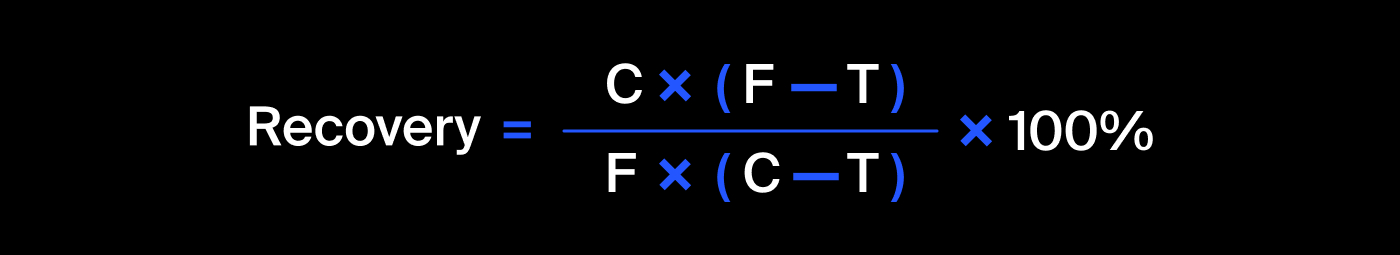

where:  
***recovery*** is the recovery percentage (`rougher.output.recovery` or `final.output.recovery`);  
***C*** is the share of gold in the concentrate after flotation/cleaning (e.g. `rougher.output.concentrate_au`);  
***F*** is the share of gold in the raw material/concentrate before flotation/cleaning(e.g. `rougher.input.feed_au`);  
***T*** is the share of gold in final tailings after flotation/cleaning (e.g. `rougher.output.tail_au`).  

In [11]:
C = df_full["rougher.output.concentrate_au"]
F = df_full["rougher.input.feed_au"]
T = df_full["rougher.output.tail_au"]
recovery_calculated = C / F * (F - T) / (C - T) * 100

Calculate MAE:

In [12]:
MAE = abs(df_full['rougher.output.recovery'] - recovery_calculated).mean()
print(f'{MAE = :.2e} %')

MAE = 1.14e-14 %


The metric is negligible, which means that the correct recovery value is present in the training sample.

### Data cleaning

Several lists of features for further analysis are prepared:

1. Lists of positive features (for logscale plotting) for training and test datasets;
2. Lists of negative features (**...level** features);
3. List of important features, outliers from which will not be specifically deleted. These are the features that are marked important for random tree regression, see section 3.4.1 for details.

In [13]:
columns_all_train = df_train_full.columns.tolist()
columns_negative_train = df_train_full.filter(regex=".*level").columns.tolist()
columns_positive_train = df_train_full[columns_all_train].drop(columns_negative_train, axis=1).columns.tolist()

In [14]:
columns_all_test = df_test.columns.tolist()
columns_negative_test = df_test.filter(regex=".*level").columns.tolist()
columns_positive_test = df_test[columns_all_test].drop(columns_negative_test, axis=1).columns.tolist()

In [15]:
important_features = [
    'rougher.state.floatbank10_c_air', 
    'rougher.state.floatbank10_a_air',
    'rougher.state.floatbank10_f_air',
    'rougher.state.floatbank10_a_level',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_size',
    'primary_cleaner.input.sulfate',
    'secondary_cleaner.state.floatbank2_a_air',   
]

Set the x limits to display and prepare function for plotting boxplots:

In [16]:
x_lim_norm = [-1000, 0]
x_lim_log = [10e-4, 10e4]

In [17]:
def plot_boxplot(data_to_plot, column_labels, title, x_lim=None, data_to_compare=None):
    f, ax = plt.subplots(figsize=(14, len(column_labels)))
    sns.boxplot(data=data_to_plot[column_labels], orient='h')
            
    if data_to_compare is not None:  # second boxplot on the same figure for comparison
        sns.boxplot(
            data_to_compare[column_labels], 
            orient='h', 
            width=0.5, 
            color='white', 
            saturation=0.2, 
            fliersize=2
        )
        
    if x_lim:  # choosing the scale (log or normal)
        plt.xlim(x_lim)
        if x_lim[0] == x_lim_log[0]:
            ax.set_xscale("log")
        
    ax.set_yticklabels(column_labels, size=12)
    plt.title(f'Boxplots for {title}', size=20)
    plt.show()

All data types in datasets are valid. The `date` column could be transformed to the *datetime* type, but this is not required in the current task. It remains to work with duplicates, gaps and outliers.

#### Duplicates

All values of the `date` index are unique, so there cannot be complete duplicates. However, for example, there is a possibility that the observation for the new hour duplicates the observation for the previous one. Let's see if there are any such duplicates:

In [18]:
print('Duplicates in training dataset:', df_train_full.duplicated().sum())
print('Duplicates in test dataset:', df_test.duplicated().sum())

Duplicates in training dataset: 0
Duplicates in test dataset: 0


There are no duplicates, all objects in the datasets are unique.

#### Gaps

According to the task description, "parameters adjacent in time are often similar." This means that the gaps can be filled with the *ffill* or *bfill* methods, or the `df.interpolate` function can be used. Use it for both training and test datasets:

In [19]:
df_train_full = df_train_full.fillna(method='bfill')
df_test = df_test.fillna(method='bfill')

#### Illogical values

First, let's take a look at the min and max values in columns. Following conditions should be met:
1. All features with concentration should have values in the [0, 100] interval;
2. All features except **...level** (see extended notebook for details) should not contain negative values.

In [20]:
min_max_train = df_train_full.describe().loc[['min', 'max']]

In [21]:
# check if any concentrations values are > 100%
print('\033[1mTrain dataset, number of features with max concentration features values > 100%:\033[0m')
display(
    (df_train_full.filter(regex=(".*concentrate.+|tail|recovery")).max() > 100).sum()
)

Train dataset, number of features with max concentration features values > 100%:


0

In [22]:
# check if there are negative values where they shouldn't be
print('\033[1mTrain dataset, min values in columns with negative values:\033[0m')
display(
    min_max_train.loc[:,(min_max_train < 0).any()].drop(  
    columns_negative_train, axis=1
    ).T['min']
)

Train dataset, min values in columns with negative values:


rougher.calculation.sulfate_to_au_concentrate        -4.223520e+07
rougher.calculation.floatbank10_sulfate_to_au_feed   -4.865987e+02
rougher.calculation.floatbank11_sulfate_to_au_feed   -2.649828e+02
rougher.calculation.au_pb_ratio                      -1.054761e-02
rougher.state.floatbank10_a_air                      -4.107792e-02
rougher.state.floatbank10_b_air                      -6.533838e-01
rougher.state.floatbank10_c_air                      -3.511233e-02
rougher.state.floatbank10_d_air                      -5.542987e-01
rougher.state.floatbank10_e_air                      -1.970275e+00
rougher.state.floatbank10_f_air                      -2.430587e+00
secondary_cleaner.state.floatbank5_a_air             -3.720540e-01
Name: min, dtype: float64

All concentration features are OK. Some **...air** and **calculation** features have negative values, which will be deleted for this task. 
  
The same analysis for **df_test** dataset:

In [23]:
min_max_test = df_test.describe().loc[['min', 'max']]

In [24]:
# check if any concentrations values are > 100%
print('\033[1mTest dataset, number of features with max concentration features values > 100%:\033[0m')
display(
    (df_train_full.filter(regex=(".*concentrate.+|tail|recovery")).max() > 100).sum()
)

Test dataset, number of features with max concentration features values > 100%:


0

In [25]:
# select all columns with negative values except "level" columns and display min values
print('\033[1mTest dataset, min values in columns with negative values:\033[0m')
display(
    min_max_test.loc[:,(min_max_test < 0).any()].drop(  
    columns_negative_test, axis=1
    ).T['min']
)

Test dataset, min values in columns with negative values:


rougher.state.floatbank10_a_air            -0.042069
rougher.state.floatbank10_b_air            -0.721806
rougher.state.floatbank10_c_air            -0.056636
rougher.state.floatbank10_d_air            -0.992219
rougher.state.floatbank10_e_air            -1.982295
rougher.state.floatbank10_f_air            -2.593390
secondary_cleaner.state.floatbank6_a_air   -0.079426
Name: min, dtype: float64

As for the training dataset, all concentration features are OK and some **...air** features have negative values.

Remove negative values where they are illogical (all but **...level** features):

In [26]:
for column in columns_positive_train:    
    df_train_full = df_train_full.drop(
        df_train_full[df_train_full[column] < 0].index
    )
for column in columns_positive_test:
    df_test = df_test.drop(df_test[df_test[column] < 0].index)

No other values in datasets seem to be illogical (e.g. no concentration values that are >100%). However, it is possible that all concentrations at a certain process stage make up for more than 100%. Checking it:

In [27]:
# returns all column names for concentration features (au, ag, pb, sol) for a passed stage 
def select_columns(stage_name):
    return df_train_full.filter(regex=(f'{stage_name}.*')).columns.tolist()

In [28]:
# get a dictionary for easier plotting
all_stages_concentrations = {
    'rougher_input': select_columns('rougher.input.feed_([ap]|sol)'), # this stage has some more "feed_" params
    'rougher_output': select_columns('rougher.output.concentrate'),
    'primary_cleaner_output': select_columns('primary_cleaner.output.concentrate'), 
    'final_output': select_columns('final.output.concentrate'), 
    'rougher_output_tail': select_columns('rougher.output.tail'), 
    'primary_cleaner_output_tail': select_columns('primary_cleaner.output.tail'),
    'secondary_cleaner_output_tail': select_columns('secondary_cleaner.output.tail'), 
    'final_output_tail': select_columns('final.output.tail'),    
}

In [29]:
aggregate_concentrations_per_stage = pd.DataFrame()

# get dataframe with sums of all component concentrations for given stage
for name, stage in all_stages_concentrations.items():   
    aggregate_concentrations_per_stage[name] = df_train_full[stage].sum(axis=1)    

In [30]:
# check dataframe structure
aggregate_concentrations_per_stage.head(1)

,rougher_input,rougher_output,primary_cleaner_output,final_output,rougher_output_tail,primary_cleaner_output_tail,secondary_cleaner_output_tail,final_output_tail
date,,,,,,,,
2016-01-15 00:00:00,51.680034,66.42495,72.640924,63.644396,25.841287,27.054192,30.565842,30.354855


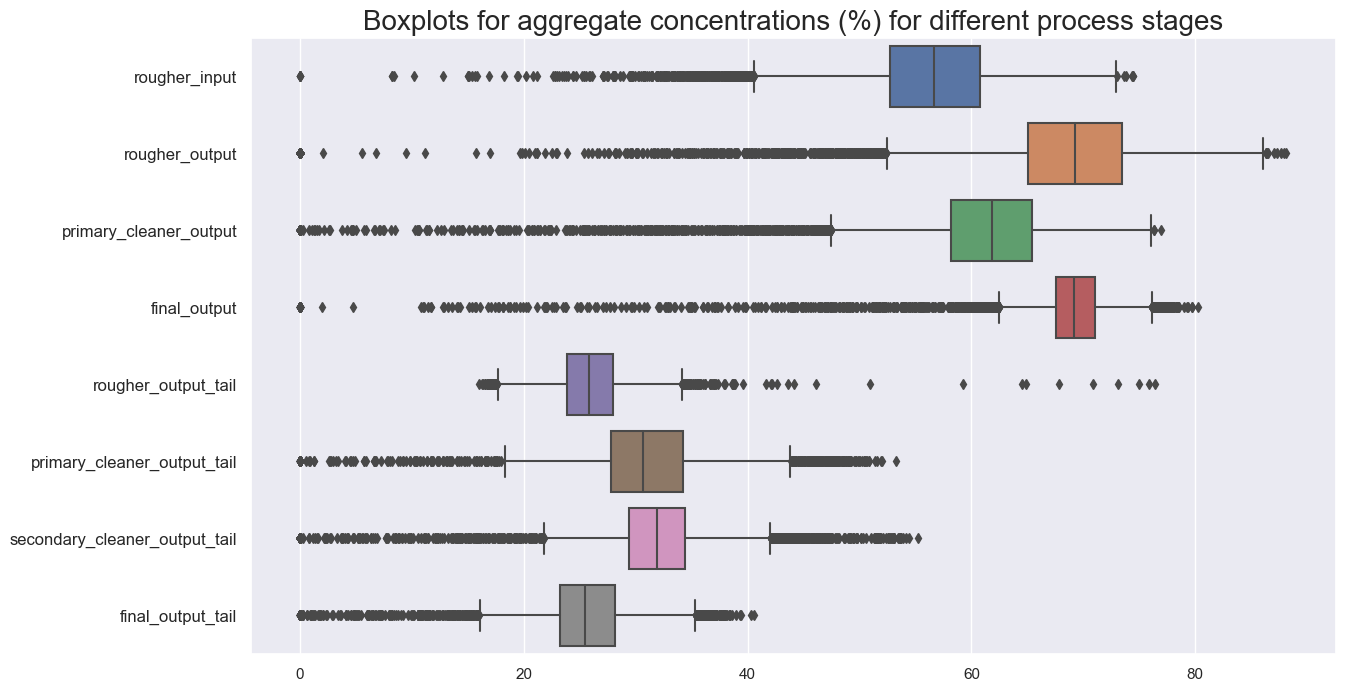

In [31]:
plot_boxplot(
    aggregate_concentrations_per_stage, 
    aggregate_concentrations_per_stage.columns, 
    'aggregate concentrations (%) for different process stages'
)

No mistakes here, all aggregate concentrations are <100%.

#### Outliers

The situation with outliers is quite complicated, as there are 86 features in the dataset.   
To study outliers in other features, we will use boxplots. Here we randomly select 10 non-negative features and plot distribution boxplots for them. A more thorough study is presented in *notebook_extended*.

In [32]:
from random import sample
# select features for boxplot
features_for_boxplot = sample(columns_positive_train, 10)

Plot selected non-negative features using log scale:

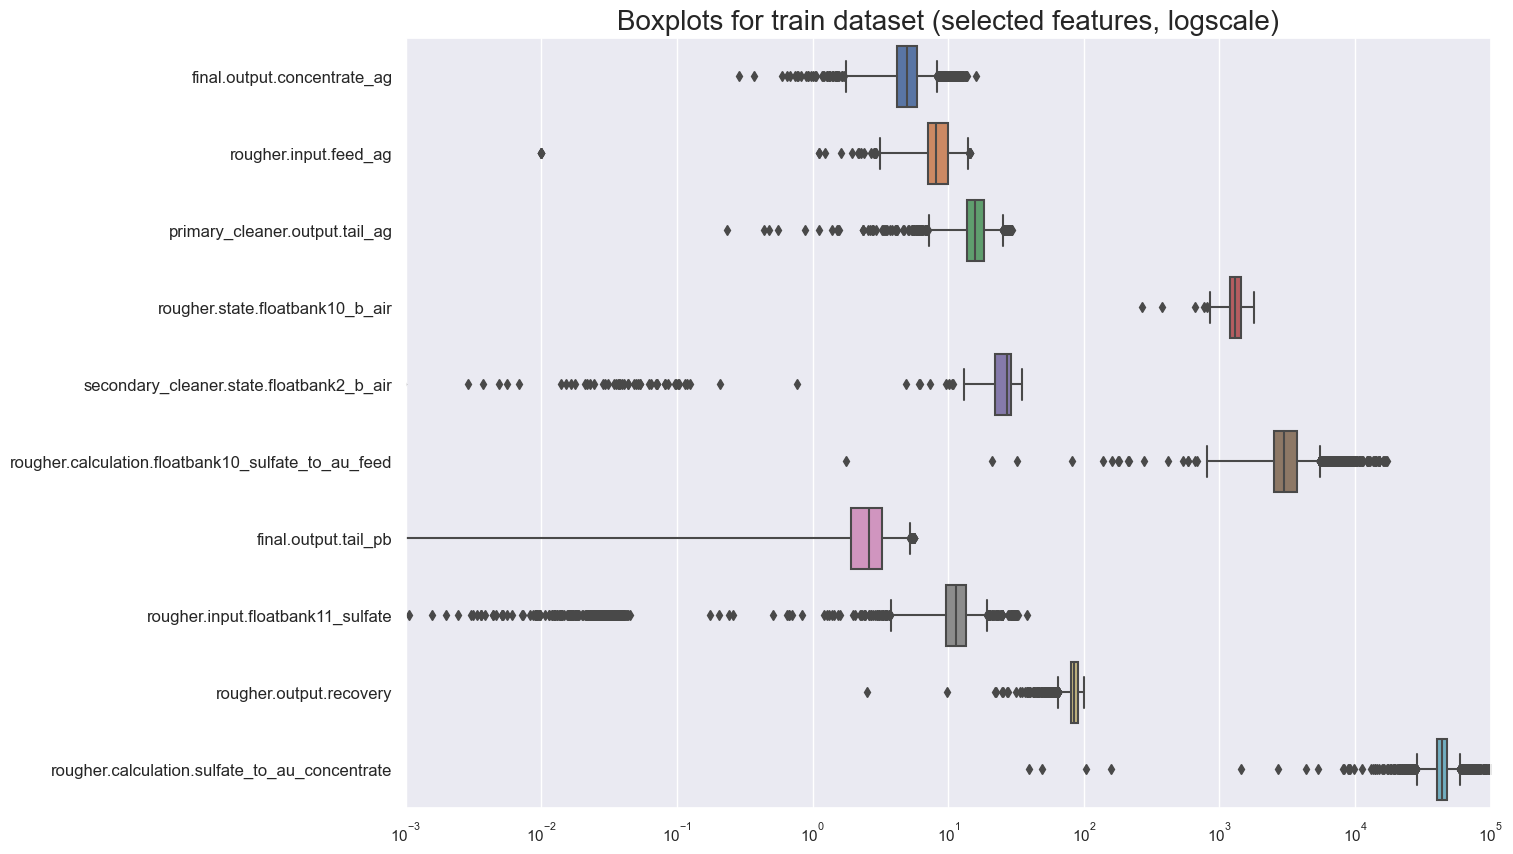

In [33]:
plot_boxplot(
    df_train_full, 
    features_for_boxplot, 
    'train dataset (selected features, logscale)', 
    x_lim=x_lim_log
)

By analyzing this "partial" boxplot it is clear that for the given dataset it is common that there are quite a lot of explicit lower outliers and comparatively less upper outliers.

A rather lazy brute force approach for outliers cleaning is proposed: simply cut off 0.2% of the upper and 0.1% of the lower outliers in each column (taking into account the fact that the same observation can be an outlier for several features at once).

The advantage of this approach is that it saves a lot of time, and the main disadvantage is that we lose quite a lot of useful information. However, this approach might come in handy for random forest or linear regression models.
  
The new information will be stored in new dataset `df_train`, whilst the data without cleaning will be stored in `df_train_full`. We will later compare model performance on both datasets and conclude if this cleaning method is justified.

In [34]:
index_to_drop = []  # list of indices to drop

for column in [column for column in columns_all_train if column not in important_features]:
    c_1 = df_train_full[column] < df_train_full[column].quantile(0.999)  # get Series of True/False with this condition
    c_2 = df_train_full[column] > df_train_full[column].quantile(0.002)  # if False, it's an outlier

    for ind in c_1.index[c_1 == False]:  # append indices of outliers
        index_to_drop.append(ind)
    for ind in c_2.index[c_2 == False]:
        index_to_drop.append(ind)
        
index_to_drop = set(index_to_drop)  # remove indices duplicates

In [35]:
print(f'{len(index_to_drop) = }')

len(index_to_drop) = 2622


The approach is quite extravagant, as we cut off 20% of the train dataset.

In [36]:
df_train = df_train_full.drop(index_to_drop)

How the feature distributions look in the training dataset after the outliers were removed:

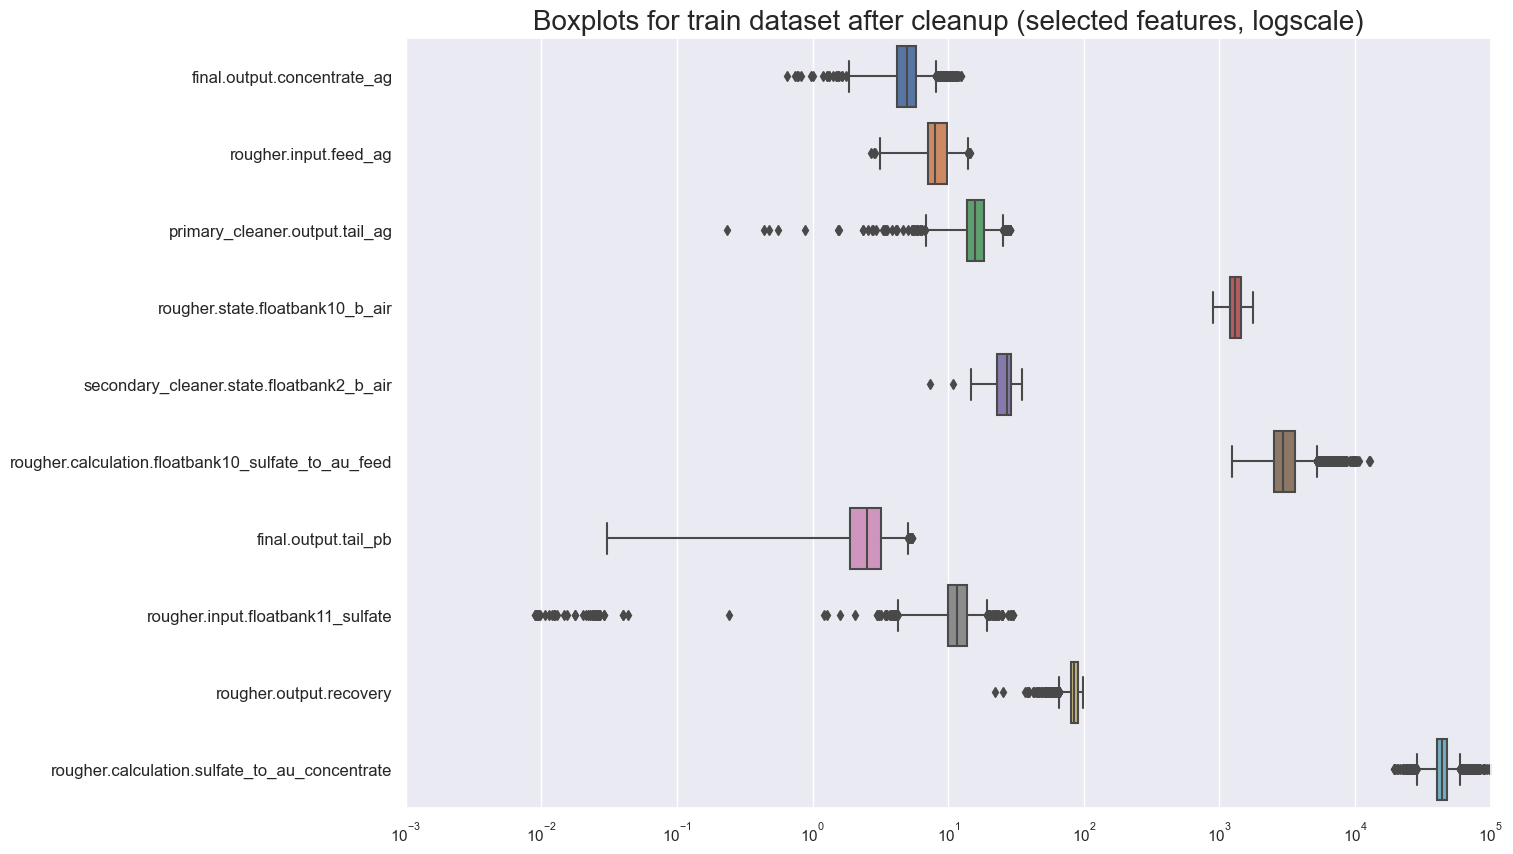

In [37]:
plot_boxplot(
    df_train,
    features_for_boxplot, 
    'train dataset after cleanup (selected features, logscale)', 
    x_lim=x_lim_log
)

The number of explicit outliers visually was significantly reduced.  
The data preprocessing for training dataset has been completed. If any preprocessing is required for the test dataset, it will be covered in the next chapter.

## Data analysis

To gain a deeper understanding of the technological process, analyses of some features are conducted in this section. The mean concentrations of metals at each process stage, the distributions of aggregate metal concentrations at each process stage and the equality of distributions of features in training and test datasets are investigated.

### Mean metal concentrations

The following code is used to calculate the mean concentration of each metal on every stage of technological process:

In [38]:
def return_concentrations(metal):
    '''
    Function selects corresponding features for the given metal.
    Returns a list of mean concentrations for every stage for the given metal for every obervation.
    '''
    mean_conc = df_full[
        [
            f"rougher.input.feed_{metal}",
            f"rougher.output.concentrate_{metal}",
            f"primary_cleaner.output.concentrate_{metal}",
            f"final.output.concentrate_{metal}",
        ]
    ]
    mean_conc = mean_conc.apply('mean')
    return mean_conc

In [39]:
# get 3 dataframes with all calculations for the given metal
mean_au = return_concentrations('au')
mean_ag = return_concentrations('ag')
mean_pb = return_concentrations('pb')

In [40]:
# get xlabels
stages = ['rougher.input', 'rougher.output', 'primary_cleaner.output', 'final.output']

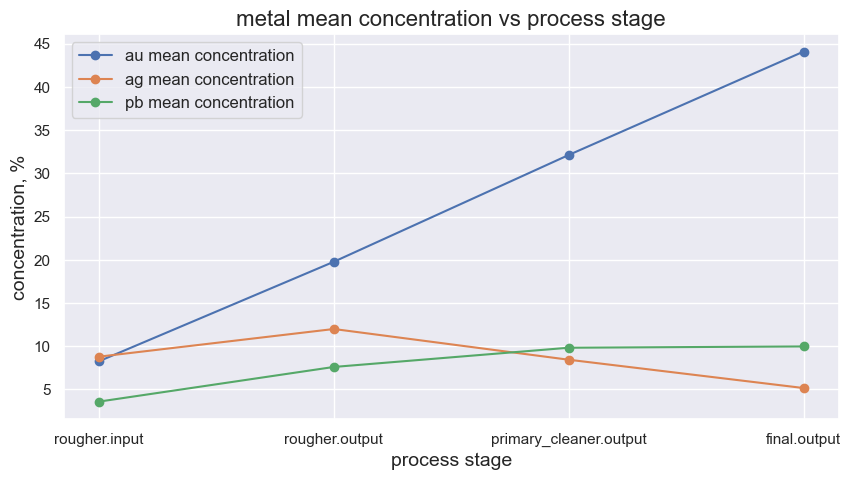

In [41]:
# plot figures
plt.figure(figsize=(10,5))
plt.plot(stages, mean_au, marker='o', label='au mean concentration')
plt.plot(stages, mean_ag, marker='o', label='ag mean concentration')
plt.plot(stages, mean_pb, marker='o', label='pb mean concentration')

plt.legend(fontsize=12)
plt.xlabel('process stage', fontsize=14)
plt.ylabel('concentration, %', fontsize=14)
plt.title('metal mean concentration vs process stage', fontsize=16)

plt.show()

The figure shows the change of average concentration of gold, silver and lead at different process stages.
Mean concentration of gold experiences a stable increase (from 8% in raw materials to 44% in the final product). The concentration of lead, at the same time, grows only slightly, while that of silver decreases towards the final stage after a rise from 8% to 12% during first two process steps. 
  
The process is designed to concentrate gold. It is useful to know, if this process is robust and allows to get higher concentrations of metals consistently, or there are many cases of failed enrichment. To get a better understanding of this, we will investigate the distributions of aggregate metal concentrations at each stage.

### Aggregate metal concentrations distribution

When gold is recovered from ore, impurities (in particular, the sol) are removed. If the process works correctly, the aggregate metal concentration should increase with each process stage.

To verify this, histograms of the total concentrations of metals at each stage of the process are constructed:

In [42]:
aggregate_concentrations = pd.DataFrame()

for stage in stages:   
    # add up all possible concentrations of metals for each stage and add to dataframe
    aggregate_concentrations[stage] =\
          df_train.filter(regex=f'{stage}.concentrate_[a-z]{{2}}$|{stage}.feed_[a-z]{{2}}$').sum(axis=1)    
    
    # checking the correctness of regex
    print(f'{stage = }', 
      '\nColumns to sum:', 
      df_train.filter(regex=f'{stage}.concentrate_[a-z]{{2}}$|{stage}.feed_[a-z]{{2}}$').columns.tolist(), 
      '\n')

stage = 'rougher.input' 
Columns to sum: ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au'] 

stage = 'rougher.output' 
Columns to sum: ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au'] 

stage = 'primary_cleaner.output' 
Columns to sum: ['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_au'] 

stage = 'final.output' 
Columns to sum: ['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au'] 



The mean values of aggregate concentrations at each process stage:

In [43]:
aggregate_concentrations.apply('mean')

rougher.input             19.881900
rougher.output            39.663343
primary_cleaner.output    50.676499
final.output              59.722799
dtype: float64

It's clear from this table that mean aggregate concentration of metals grows with every process step.

Plot the histograms:

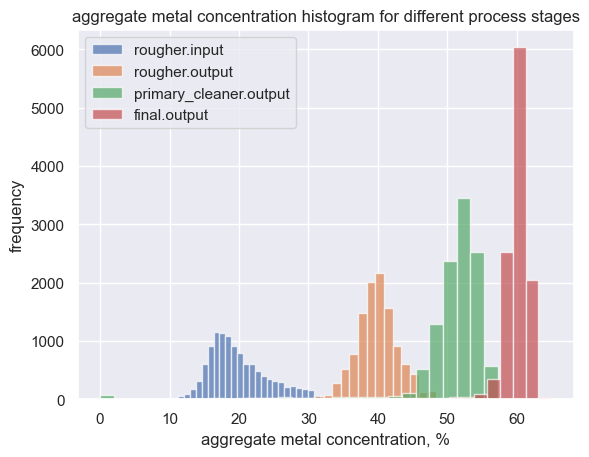

In [44]:
for column in aggregate_concentrations.columns:
    aggregate_concentrations[column].hist(label=column, alpha=0.7, bins=30)

plt.title('aggregate metal concentration histogram for different process stages')
plt.xlabel('aggregate metal concentration, %')
plt.ylabel('frequency')
plt.legend()
plt.show()

As it was indicated earlier, the total concentration of metals, in general, increases with the stage of the technological process.

At the same time, there is a rather strange anomaly in the test sample: after the primary cleaning stage, the total concentration of metals can drop sharply there is a column near 0 on the corresponding histogram). This happens after the lower 0.2% data in the column was cut off. Let's study these anomalies:

In [45]:
outliers = aggregate_concentrations[aggregate_concentrations['primary_cleaner.output'] < 1].index

In [46]:
# number of outliers after primary cleaning process stage:
len(outliers)

77

In [47]:
print('rows with outliers:')
aggregate_concentrations[aggregate_concentrations['primary_cleaner.output'] < 1].head(8)

rows with outliers:


,rougher.input,rougher.output,primary_cleaner.output,final.output
date,,,,
2017-04-12 01:59:59,20.778967,39.537504,0.706329,59.773652
2017-07-13 04:59:59,17.132616,40.443428,0.096607,58.069369
2018-02-17 17:59:59,21.388213,39.668877,0.030000,59.582703
2018-02-17 18:59:59,20.805423,40.164465,0.030000,60.155330
2018-02-17 19:59:59,20.047464,40.654229,0.030000,60.751214
2018-02-21 14:59:59,15.128186,42.388053,0.030000,12.536783
2018-02-22 07:59:59,20.664600,43.491038,0.030000,60.647697
2018-02-22 22:59:59,17.927621,39.981321,0.030000,60.570342


There is a number of anomalies, many of which are consecutive in time. They are observed only after the primary cleaning stage. Either there is some error / feature in the technological process, or an error in the concentration calculation. This can also be the result of `ffill` gaps fill method. Since we have already got rid of 0.2% lower outliers, these values seem to be a pattern that should not be ignored, so they won't be removed from datasets.

### Equality of distributions in train and test datasets

In order to make sure that our models will work for the test dataset, the feature distributions for test and train datasets should be compared. 

#### Selected distributions

Let's compare distributions of a subset of features first and then investigate feed size (one of the most important features) distributions in more detail. Plotting boxplots for both test and training dataset on one figure (training dataset is white):

In [48]:
features_for_boxplot = sample(columns_positive_test, 10)

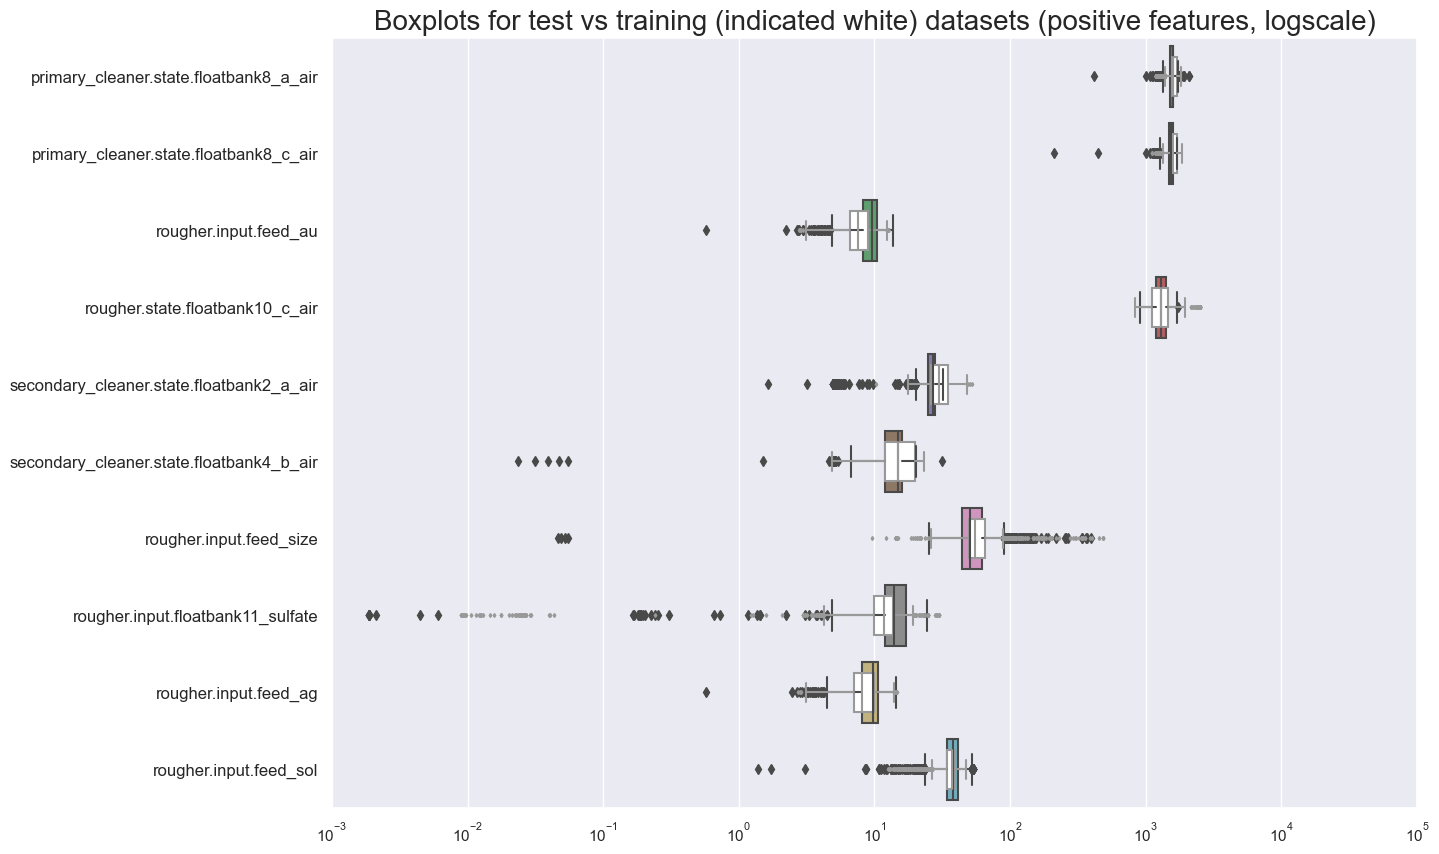

In [49]:
plot_boxplot(
    df_test, 
    features_for_boxplot, 
    'test vs training (indicated white) datasets (positive features, logscale)', 
    x_lim=x_lim_log,
    data_to_compare=df_train
)

All the selected features are distributed similarly. However, it is seen that many features in test dataset also have the outliers. To improve the final metrics on test dataset, these outliers can also be deleted. 
  
The comparison of all dataset features are in the *notebook_extended*. 
  
For this task no additional preprocessing will be conducted and all observations are supposed to be a sample from the same population. One of the distributions will be investigated in more detail as an example.

#### Distributions of feed size

Input granule feed size for rougher process is an important feature for recovery prediction (see 3.4.1 for details). Significantly different distributions can lead to greater errors in model predictions. To verify that there is no significant difference in distribution, kde plots were constructed:

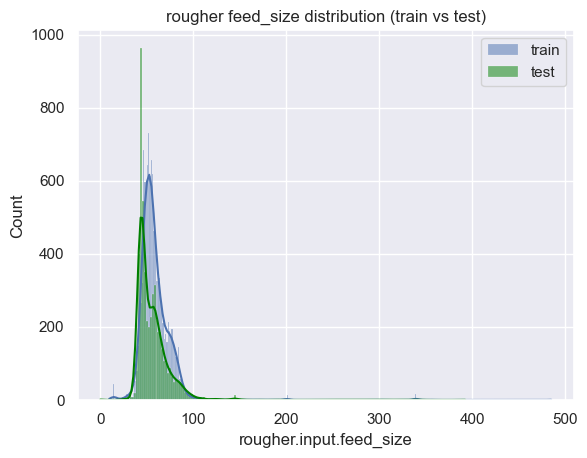

In [50]:
sns.histplot(
    df_train, 
    x='rougher.input.feed_size', 
    label='train',
    kde=True
).set_title('rougher feed_size distribution (train vs test)')

sns.histplot(
    df_test, 
    x='rougher.input.feed_size', 
    color='green', 
    alpha=0.5, 
    label='test',
    kde=True
)

plt.legend()
plt.show()

The feed size distribution in the training and test samples in the initial raw material visually differs only slightly. We can perform a stat test to verify that this difference is significant. 

**Let H0: "Mean input feed sizes for training and test samples are the same"**

In [51]:
# get numbers of observations
nobs1 = len(df_train['rougher.input.feed_size'])
nobs2 = len(df_test['rougher.input.feed_size'])

In [52]:
# calculate p-value for ttest for training and test data
def ttest(parameter):
    mean1 = df_train[parameter].mean()
    std1 = df_train[parameter].var()
    
    mean2 = df_test[parameter].mean()
    std2 = df_test[parameter].var()
    
    _, p_val = ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2, equal_var=False)
    print("p-value:", p_val)

In [53]:
ttest('rougher.input.feed_size')

p-value: 0.6250676160024302


The p-value for comparison of rougher input feed size for training and test datasets is quite high. We don't reject the null hypothesis. Mean input feed size for rougher process is the same for training and test datasets.
  
Perform the same plotting for `primary_cleaner.input.feed_size`:

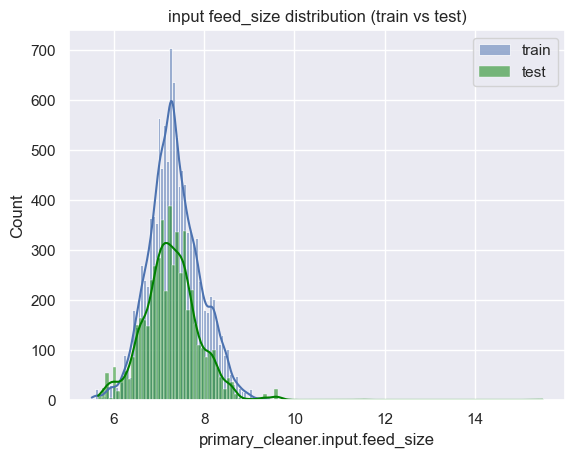

In [54]:
sns.histplot(
    df_train, 
    x='primary_cleaner.input.feed_size', 
    label='train',
    kde=True
).set_title('input feed_size distribution (train vs test)')

sns.histplot(
    df_test, 
    x='primary_cleaner.input.feed_size', 
    color='green', 
    alpha=0.5, 
    label='test',
    kde=True
)

plt.legend()
plt.show()

The grain size distributions in the training and test samples are visually equal. Running a statistical test:

In [55]:
ttest('primary_cleaner.input.feed_size')

p-value: 1.2290406694510654e-35


The p-value is very low, reject the null hypothesis. Mean input feed size is different for training and test datasets for the primary cleaner input.

Though a statistically significant difference for feed sizes for train and test samples for rougher process was found, it was decided to not to perform any additional preprocessing, as the distirbutions are visually very close. 
  
*P.S. Another option is to center the data before the machine learning, but this doesn't provide good results in the given task.*

## Machine learning

After preprocessing and analyzing the data, it's time for predictions. In this chapter datasets are split, functions for calculation of task metrics are written and the best model on cross-validation is found. The model is then used to predict values on test dataset.
  
Following models are in scope:
1. Linear regression (*sklearn LinearRegressor*)
2. Random forest regression (*sklearn RandomForestRegressor*)
3. Gradient boosting (*CatBoostRegressor*)
  
To work with the models, the dataset splitting should be performed.

### Train and test datasets splitting

We will use **different** samples from training dataset to train models for prediction of either `rougher.output.recovery` or `final.output.recovery`. We can predict the latter using the full train dataset, while for the former it is reasonable to use only the **rougher...** columns. All other columns contain information for further processes that is gained already after we know `rougher.output.recovery` for current observation. These columns should not be used for training models to predict `rougher.output.recovery`.

This is a custom function that provides the desired split. It receives a dataset and returns split data as a dictionary:

In [56]:
def custom_split(df, suffix=None):
    X_rougher = df.filter(
        regex="rougher.*"  # other columns contain excessive info for prediction of rougher
    ).drop('rougher.output.recovery', axis=1)  
    y_rougher = df['rougher.output.recovery']
    
    X_final = df.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1) 
    y_final = df['final.output.recovery']
    
    # print the shapes of split dataset for check
    print(f'X_rougher_{suffix}.shape = {X_rougher.shape}')
    print(f'y_rougher_{suffix}.shape = {y_rougher.shape}')
    print(f'X_final_{suffix}.shape = {X_final.shape}')
    print(f'y_final_{suffix}.shape = {y_final.shape}')
    
    return {
        'X_rougher': X_rougher, 
        'y_rougher': y_rougher, 
        'X_final': X_final, 
        'y_final': y_final
    }

Columns that are not in the test dataset are not needed for the task. These extra columns of the training sample are to be removed. 
  
We will use two datasets to investigate if the proposed outlier removal strategy is correct:
1. Dataset with outliers (**df_train**)
2. Dataset without outliers (**df_train_full**)

In [57]:
columns_to_leave = df_test.columns.tolist()  # leave only columns that are in df_test
columns_to_leave.extend(('rougher.output.recovery', 'final.output.recovery'))

df_train = df_train[columns_to_leave]  # dataset without outliers
df_train_full = df_train_full[columns_to_leave]  # dataset with outliers

#### Test dataset split

In order to estimate the model quality we should know the true values of the target labels. They can be obtained from **df_full**:

In [58]:
df_test = df_test.join(df_full[['rougher.output.recovery', 'final.output.recovery']])

Checking that the columns are added correctly:

In [59]:
df_test.iloc[:,-3:].head()

,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,
2016-09-01 00:59:59,-499.709414,89.993421,70.273583
2016-09-01 01:59:59,-499.819438,88.089657,68.910432
2016-09-01 02:59:59,-500.622559,88.412756,68.143213
2016-09-01 03:59:59,-498.709987,87.360133,67.776393
2016-09-01 04:59:59,-500.856333,83.236367,61.467078


In [60]:
df_test.shape

(5288, 54)

Split test dataset into features and target for rougher and final recovery predictions:

In [61]:
test_dataset = custom_split(df_test, 'test')

X_rougher_test.shape = (5288, 22)
y_rougher_test.shape = (5288,)
X_final_test.shape = (5288, 52)
y_final_test.shape = (5288,)


#### Training dataset split

2 training datasets are used to train the models (**df_train**, **df_train_full**) to evaluate the proposed outlier removal strategy. **df_full** is additionaly used with feature selection to investigate if this technique can improve model quality. The following training datasets are obtained:
1. Dataset with outliers (**df_train_full**)
2. Dataset without outliers (**df_train**)
3. Dataset without outliers with feature selection (**df_train_fs**)


The results of models trained on different datasets will be compared and the best approach for training dataset preparation will be chosen.

**Split of training dataset containing outliers (df_train_full):**

A separate dataset is used to evaluate the outlier removal efficiency. This dataset contains all outliers.

In [62]:
train_dataset_full = custom_split(df_train_full[columns_to_leave], 'train_full')

X_rougher_train_full.shape = (13959, 22)
y_rougher_train_full.shape = (13959,)
X_final_train_full.shape = (13959, 52)
y_final_train_full.shape = (13959,)


Models trained on this dataset will be labeled with "full" in this chapter (e.g. LR (full) etc.)

---

**Split of training dataset without outliers (df_train):**

Training dataset is split into two X_train and two target y_train samples (for rougher and final stages recovery):

In [63]:
train_dataset = custom_split(df_train, 'train')

X_rougher_train.shape = (11337, 22)
y_rougher_train.shape = (11337,)
X_final_train.shape = (11337, 52)
y_final_train.shape = (11337,)


Models trained on this dataset will not have any naming indications throughout this chapter (e.g. will be labeled just as LR or RFR).

---

**Split of training dataset with feature selection (df_train_fs):**

As there are many features in dataset, some may be uninformative. It might be useful to remove those features to improve model performance. A simple FeatureSelector library is used for this task.

In [64]:
fs_rougher = FeatureSelector(data=train_dataset['X_rougher'], labels=train_dataset['y_rougher'])
fs_final = FeatureSelector(data=train_dataset['X_final'], labels=train_dataset['y_final'])

***Collinear features:***

In [65]:
fs_rougher.identify_collinear(correlation_threshold=0.95)

5 features with a correlation magnitude greater than 0.95.



In [66]:
fs_final.identify_collinear(correlation_threshold=0.95)

7 features with a correlation magnitude greater than 0.95.



***Zero and low importance features:***

In [67]:
fs_final.identify_zero_importance(
    task = 'regression', eval_metric='r2', n_iterations=10, early_stopping=True
)
fs_final.identify_low_importance(cumulative_importance = 0.99)

Training Gradient Boosting Model


0 features with zero importance after one-hot encoding.

51 features required for cumulative importance of 0.99 after one hot encoding.
1 features do not contribute to cumulative importance of 0.99.



In [68]:
fs_rougher.identify_zero_importance(
    task="regression", eval_metric="r2", n_iterations=10, early_stopping=True
)
fs_rougher.identify_low_importance(cumulative_importance=0.99)

Training Gradient Boosting Model


0 features with zero importance after one-hot encoding.

21 features required for cumulative importance of 0.99 after one hot encoding.
1 features do not contribute to cumulative importance of 0.99.



In [69]:
display(fs_rougher.ops['low_importance'])
display(fs_final.ops['low_importance'])

['rougher.input.floatbank11_sulfate']

['rougher.input.floatbank11_sulfate']

***Removal:***

All the collinear and low importance features will be removed for the resulting dataset:

In [70]:
X_rougher_train_fs = fs_rougher.remove(methods=['low_importance', 'collinear'])
X_final_train_fs = fs_final.remove(methods=['low_importance', 'collinear'])

Removed 5 features.
Removed 7 features.


In [71]:
# building a dictionary for the FS dataset
train_dataset_fs = {
    'X_rougher': X_rougher_train_fs, 
    'y_rougher': train_dataset['y_rougher'], 
    'X_final': X_final_train_fs, 
    'y_final': train_dataset['y_final']
}

In [72]:
# compare the numbers of features in "regular" and FS datasets
print(f'{train_dataset["X_rougher"].shape = }')
print(f'{train_dataset_fs["X_rougher"].shape = }')
print()
print(f'{train_dataset["X_final"].shape = }')
print(f'{train_dataset_fs["X_final"].shape = }')

train_dataset["X_rougher"].shape = (11337, 22)
train_dataset_fs["X_rougher"].shape = (11337, 17)

train_dataset["X_final"].shape = (11337, 52)
train_dataset_fs["X_final"].shape = (11337, 45)


Models trained on this dataset will be labeled with FS (feature selection) in this chapter (e.g. LR (FS) etc.)

### Metrics calculations

The sMAPE metric is set in the task description to determine the quality of the model. Smaller metric value means better predictions by model:

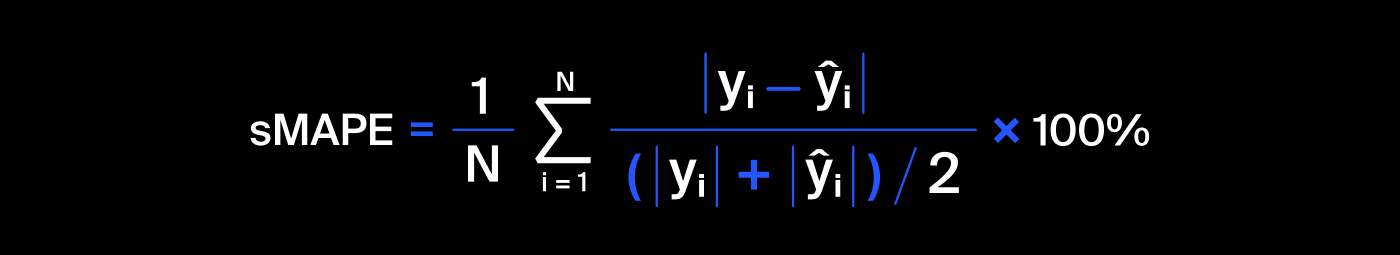

In [73]:
def calculate_sMAPE(y, y_pred):
    return 200 / len(y) * (abs(y - y_pred) / (abs(y) + abs(y_pred))).sum() 

The resulting sMAPE is calculated based on sMAPE for `final.output.recovery` and `rougher.output.recovery` predictions: 

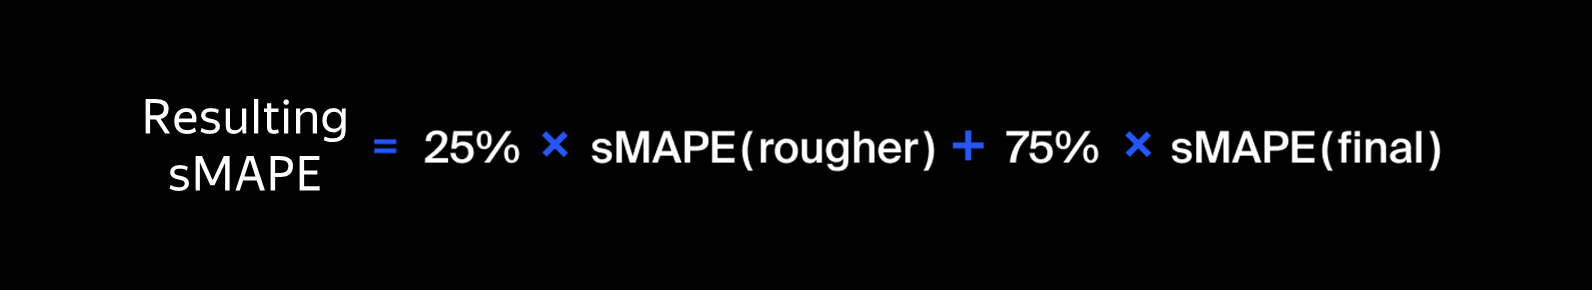

The following class serves for the purpose of this calculation:

In [74]:
class Resulting_sMAPE:
    def __init__(self, error_rougher, error_final, model_name='*not stated*'):  # receives calculated sMAPE for rougher/final
        self.error_rougher = error_rougher
        self.error_final = error_final
        self.model_name = model_name
    
    def score(self):  # returns resulting sMAPE value
        return round(abs(0.25 * self.error_rougher + 0.75 * self.error_final), 2)
    
    def print_score(self): # prints resulting sMAPE value
        print(f'Resulting sMAPE score for {self.model_name} = {self.score():.2f}%')

Create a scorer to pass the metric as an argument to the models:

In [75]:
scorer = make_scorer(calculate_sMAPE, greater_is_better=False)

All the metrics for different models will be added to a dictionary for final comparison: 

In [76]:
metrics = {}

This is a reusable code that fits the given model on rougher and final samples. Returns fit models (as *GridSearchCV* objects) and sMAPE object:

In [77]:
def model_fit_gridsearch(model, parameters, dataset, label="*not specified*", CV=5):
    
    """
    This function returns GridSearchCV objects for rougher and final recovery predictions by passed model.
    It also returns the sMAPE metric object and adds sMAPE for current model to metrics dict as a side effect.
    Dataset is passed as a dictionary.
    """

    grid_rougher = GridSearchCV(model, parameters, scoring=scorer, cv=CV, n_jobs=-1)
    grid_rougher.fit(dataset['X_rougher'], dataset['y_rougher'])
    
    grid_final = GridSearchCV(model, parameters, scoring=scorer, cv=CV, n_jobs=-1)
    grid_final.fit(dataset['X_final'], dataset['y_final'])

    sMAPE = Resulting_sMAPE(
        grid_rougher.best_score_, grid_final.best_score_, label
    )
    if label != "*not specified*":
        metrics[label] = sMAPE.score()  # add named metric to metrics dict

    return grid_rougher, grid_final, sMAPE

All the preparations are done, let's see the performance of simple model from sklearn to get an understanding of sMAPE magnitude.

### LinearRegression (LR)

In [78]:
# instantiate LR object and set "hyperparameters" for grid search (not much of them)
LR = LinearRegression()
parameters_LR = {'fit_intercept': [True]}

Train LR model on the 3 datasets and compare resulting metrics:

In [79]:
%%time
# fit on train dataset with outliers
grid_rougher_LR_full, grid_final_LR_full, sMAPE_LR_full = model_fit_gridsearch(
    LR, parameters_LR, train_dataset_full, label='LR (full)', CV=10
)

CPU times: total: 688 ms
Wall time: 6.74 s


In [80]:
%%time
# fit on train dataset without outliers
grid_rougher_LR, grid_final_LR, sMAPE_LR = model_fit_gridsearch(
    LR, parameters_LR, train_dataset, 'LR', CV=10
)

CPU times: total: 1.02 s
Wall time: 851 ms


In [81]:
%%time
# fit on train dataset with feature selection
grid_rougher_LR_FS, grid_final_LR_FS, sMAPE_LR_FS = model_fit_gridsearch(
    LR, parameters_LR, train_dataset_fs, 'LR (FS)', CV=10
)

CPU times: total: 938 ms
Wall time: 748 ms


In [82]:
# print scores for all three datasets
sMAPE_LR_full.print_score()
sMAPE_LR.print_score()
sMAPE_LR_FS.print_score()

Resulting sMAPE score for LR (full) = 10.80%
Resulting sMAPE score for LR = 7.94%
Resulting sMAPE score for LR (FS) = 7.81%


**Conclusion:** 
1. Removing outliers is crucial for LinearRegression model in this task. It improves the key metric by almost 3% (10.8% for model trained on dataset with outliers vs 7.94% for dataset with outliers). 
2. Feature selection also helps to improve score on 10-fold CV, but only by 0.13% (resulting sMAPE is 7.81%). 

### RFR

RFR model is trained on the same 3 datasets. Only a small subset of hyperparameters is used to save time. 

In [83]:
# instantiate RFR object and set parameters for grid search
RFR = RandomForestRegressor(random_state=11, n_jobs=-1)
parameters_RFR = {"max_depth": range(3, 6, 2), "n_estimators": range(10, 51, 20)}

In [84]:
%%time
# fit on train dataset with outliers
grid_rougher_RFR_full, grid_final_RFR_full, sMAPE_RFR_full = model_fit_gridsearch(
    RFR, parameters_RFR, train_dataset_full, label='RFR (full)'
)

CPU times: total: 45.3 s
Wall time: 1min 27s


In [85]:
%%time
# fit on train dataset without outliers
grid_rougher_RFR, grid_final_RFR, sMAPE_RFR = model_fit_gridsearch(
    RFR, parameters_RFR, train_dataset, 'RFR'
)

CPU times: total: 39 s
Wall time: 1min 17s


In [86]:
%%time
# fit on train dataset with feature selection
grid_rougher_RFR_FS, grid_final_RFR_FS, sMAPE_RFR_FS = model_fit_gridsearch(
    RFR, parameters_RFR, train_dataset_fs, 'RFR (FS)'
)

CPU times: total: 32.9 s
Wall time: 1min 5s


In [87]:
# print scores for all three datasets
sMAPE_RFR_full.print_score()
sMAPE_RFR.print_score()
sMAPE_RFR_FS.print_score()

Resulting sMAPE score for RFR (full) = 10.24%
Resulting sMAPE score for RFR = 7.49%
Resulting sMAPE score for RFR (FS) = 7.46%


**Conclusion:** 
1. Removing outliers is crucial for RFR model as well as for LR model. It improves the key metric by almost 3% (10.24% for model trained on dataset with outliers vs 7.49% for dataset with outliers).
2. Resulting sMAPE on regular dataset (without outliers) for RFR in a 5-fold CV mode is 7.49%. This result is better by around 0.5% than predictions of LR model. 
3. Feature selection has almost zero effect on RFR model results on cross-validation.
  
A more radical feature selection can be performed in case of RFR, as we can train the model only on the top important features.  In the next using these features for RFR predictions is investigated.

#### Top important features

Getting pd.Series of important features for rougher and final recovery predictions:

In [88]:
feat_importances_rougher = pd.Series(
    grid_rougher_RFR.best_estimator_.feature_importances_, 
    index=train_dataset['X_rougher'].columns
)
feat_importances_final = pd.Series(
    grid_final_RFR.best_estimator_.feature_importances_, 
    index=train_dataset['X_final'].columns
)

Constructing plots:

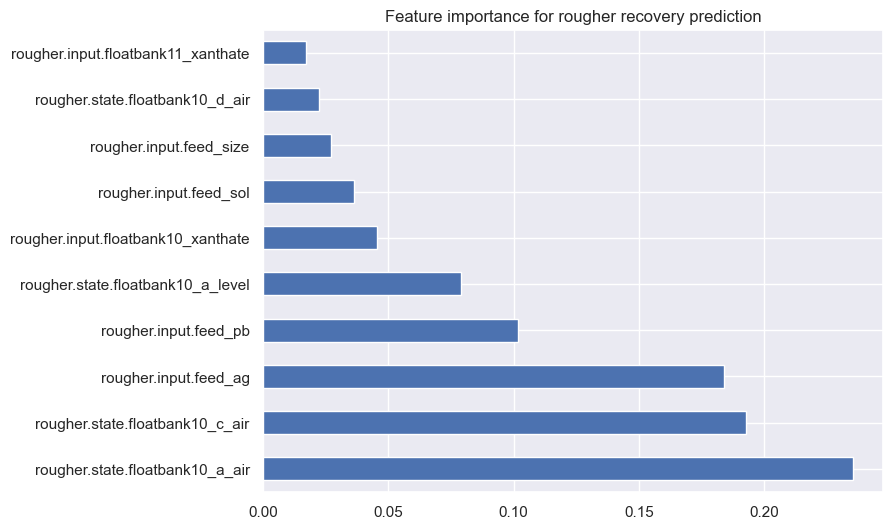

In [89]:
# plot for rougher recovery predictions
plt.figure(num=None, figsize=(8,6))

feat_importances_rougher.nlargest(10).plot(kind='barh')
plt.title('Feature importance for rougher recovery prediction')
plt.show()

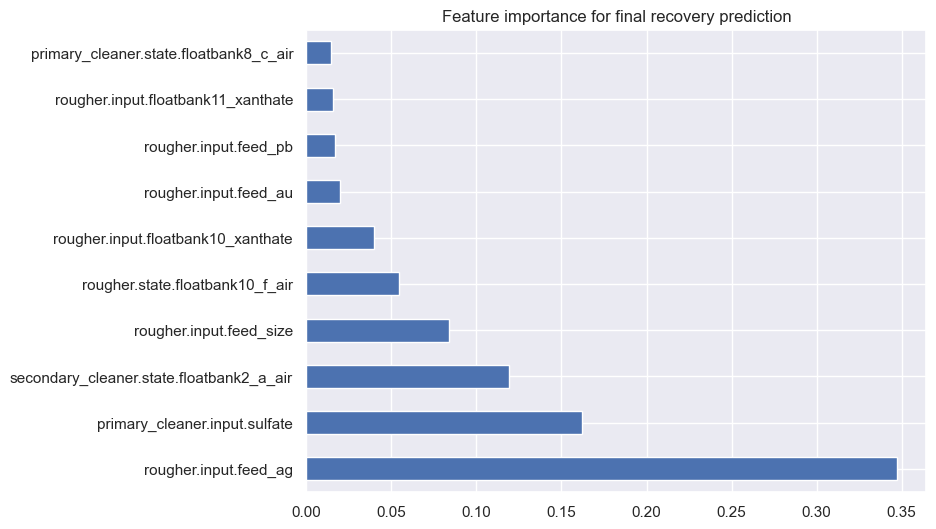

In [90]:
# plot for final recovery predictions
plt.figure(figsize=(8,6))

feat_importances_final.nlargest(10).plot(kind='barh')
plt.title('Feature importance for final recovery prediction')
plt.show()

Most top features are either the parameters of air flow (**..air** features) or rougher input parameters. Some features like, for example, `rougher.input.feed_ag` or `rougher.input.floatbank_10_xanthate` are important for predictions of both targets.  
Top-5 for important features for predictions of both targets were already added to **important_features** list in section 2.
  
Let's try to use this information to improve model performance. Using only top features for predictions can help improve the metrics and learning rate. However, this probably is not a good idea for predictions on real test datasets.

In [91]:
selected_rougher = feat_importances_rougher.nlargest(10).index.tolist()
selected_final = feat_importances_final.nlargest(10).index.tolist()

X_rougher_train_selected = train_dataset['X_rougher'][selected_rougher]
X_final_train_selected = train_dataset['X_final'][selected_final]

train_dataset_topten = {
    'X_rougher': X_rougher_train_selected, 
    'y_rougher': train_dataset['y_rougher'],
    'X_final': X_final_train_selected, 
    'y_final': train_dataset['y_final'] 
}

In [92]:
%%time
grid_rougher_RFR_topten, grid_final_RFR_topten, sMAPE_RFR_topten = model_fit_gridsearch(
    RFR, parameters_RFR, train_dataset_topten, 'RFR (top-10)'
)

CPU times: total: 10.2 s
Wall time: 21.9 s


In [93]:
sMAPE_RFR_topten.print_score()

Resulting sMAPE score for RFR (top-10) = 7.01%


* Learning rate is 6 times faster than when we use full training dataset. 
  
* The resulting score is also slightly better (7.01% using top-10 features vs 7.49% for cross-validation on dataset with outliers).
  
Overall, RFR provided better results than LR on cross-validation. The result can be improved by tuning hyperparameters, but it's very time-consuming and a better solution is to use a gradient boosting model.

### CatBoostRegressor (gradient boosting)

Catboost is used for gradient boosting in this notebook. Hyperparameters for gridsearch and function for fitting models and returning final metrics are provided in the following block of code. A small subset of hyperparameters is used to save time, as this is a research task, not an industrial or competition one. Mean absolute error is used as loss function as Catboost doesn't allow for sMAPE usage to fit models. However, it is possible to use sMAPE for predictions by means of trained Catboost model.

In [94]:
parameters_CB = {
    'iterations': [800, 1000],
    'learning_rate': [0.1],
    'depth': [5],
    'l2_leaf_reg': [1]
}

In [95]:
def CB_fit_gridsearch(train_dataset_rougher, train_dataset_final, label="*not specified*"):
    
    """
    This function returns grid_search objects for rougher and final recovery predictions by CBR.
    It also returns the sMAPE metric object and adds sMAPE for current model to metrics dict as a side effect.
    """
    
    cb_rougher = CatBoostRegressor(
        loss_function="MAE", thread_count=-1, logging_level='Silent'  # suppress output
    )
    cb_final = CatBoostRegressor(
        loss_function="MAE", thread_count=-1, logging_level='Silent'
    )
    
    print('Evaluation on rougher')
    grid_rougher_CB = cb_rougher.grid_search(
        parameters_CB, train_dataset_rougher, plot=True, verbose=False
    )
    print('\n', 'Evaluation on final')
    grid_final_CB = cb_final.grid_search(
        parameters_CB, train_dataset_final, plot=True, verbose=False
    )
     
    # getting best sMAPE scores via Catboost built-in metrics
    sMAPE_rougher = min(
        cb_rougher.eval_metrics(data=train_dataset_rougher, metrics=["SMAPE"])["SMAPE"]
    )
    sMAPE_final = min(
        cb_final.eval_metrics(data=train_dataset_final, metrics=["SMAPE"])["SMAPE"]
    )
    sMAPE_CB = Resulting_sMAPE(sMAPE_rougher, sMAPE_final, label)
    
    # adding score to metrics dict
    if label != "*not specified*":
        metrics[label] = sMAPE_CB.score()

    return cb_rougher, cb_final, sMAPE_CB

First, train model on dataset without outliers:

In [99]:
# constructing objects for Catboost (dataset without outliers)
train_dataset_rougher_full = Pool(train_dataset_full['X_rougher'], train_dataset_full['y_rougher']) 
train_dataset_final_full = Pool(train_dataset_full['X_final'], train_dataset_full['y_final']) 

In [100]:
%%time
# training Catboost on dataset without outliers
cb_rougher_full, cb_final_full, sMAPE_CB_full = CB_fit_gridsearch(
    train_dataset_rougher_full, 
    train_dataset_final_full,
    'CB (full)'
)

Evaluation on rougher


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


 Evaluation on final


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 7min 30s
Wall time: 1min 14s


Resulting sMAPE score for this dataset:

In [101]:
sMAPE_CB_full.print_score()

Resulting sMAPE score for CB (full) = 5.32%


This result is significantly better than best results of LR (7.94%) or RFR (7.49%)!

Getting the results on dataset with outliers:

In [102]:
# constructing objects for Catboost (dataset without outliers)
train_dataset_rougher = Pool(train_dataset['X_rougher'], train_dataset['y_rougher']) 
train_dataset_final = Pool(train_dataset['X_final'], train_dataset['y_final']) 

In [103]:
%%time
# training Catboost on dataset without outliers
cb_rougher, cb_final, sMAPE_CB = CB_fit_gridsearch(
    train_dataset_rougher, 
    train_dataset_final,
    'CB'
)

Evaluation on rougher


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


 Evaluation on final


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 7min 25s
Wall time: 1min 11s


Resulting sMAPE score for this dataset:

In [104]:
sMAPE_CB.print_score()

Resulting sMAPE score for CB = 3.13%


Removing outliers from dataset helps to significantly improve the key metric (from  5.32% to 3.13%!) 
  
We can get the best MAE and hyperparameters using the following code: 

In [105]:
# display(cbr_rougher.get_best_score())  # get best score on training data
# display(cbr_rougher.get_params())  # get hyperparameters of best model on training data

The last step is to compare the obtained results with the predictions on train dataset with feature selection.

In [106]:
# constructing objects for Catboost (dataset with feature selection)
train_dataset_rougher_fs = Pool(train_dataset_fs['X_rougher'], train_dataset_fs['y_rougher']) 
train_dataset_final_fs = Pool(train_dataset_fs['X_final'], train_dataset_fs['y_final']) 

In [107]:
%%time
# training Catboost on dataset with feature selection
cb_rougher_fs, cb_final_fs, sMAPE_CB_fs = CB_fit_gridsearch(
    train_dataset_rougher_fs, 
    train_dataset_final_fs,
    'CB (FS)'
)

Evaluation on rougher


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


 Evaluation on final


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 6min 48s
Wall time: 1min 6s


In [108]:
sMAPE_CB_fs.print_score()

Resulting sMAPE score for CB (FS) = 3.12%


The resulting sMAPE score on training dataset with feature selection is almost the same as for dataset without outliers. There is surely no purpose in using this dataset for Catboost model as this approach only impairs model's predictive power without any metric gain even for training data.

**Conclusions:**
1. Gradient boosting provides overall best sMAPE on cross-validation (3.13%) from all the suggested models.
2. The proposed strategy of outliers removal proved to be successful for gradient boosting (as well as for other models), improving the key metric by more than 2% on the training dataset.
3. Feature selection technique doesn't cause any metric improvement in case of Catboost regression.

We have chosen the best model (Catboost trained on dataset without outliers). The next step is to obtain the results of this model on test data.

### Checking the best model on test data

The best model (CatBoostRegressor trained on dataset without outliers) will be used for predictions on test data. 

In [109]:
test_dataset_rougher = Pool(test_dataset['X_rougher'], test_dataset['y_rougher'])
test_dataset_final = Pool(test_dataset['X_final'], test_dataset['y_final'])

# calculating sMAPE for rougher and final
sMAPE_rougher_test = min(cb_rougher.eval_metrics(data=test_dataset_rougher, metrics=['SMAPE'])['SMAPE'])
sMAPE_final_test = min(cb_final.eval_metrics(data=test_dataset_final, metrics=['SMAPE'])['SMAPE'])

In [110]:
# calculating resulting sMAPE
sMAPE_CB = Resulting_sMAPE(
    sMAPE_rougher_test, 
    sMAPE_final_test, 
    'CB (test)'
)
metrics['CB (test)'] = sMAPE_CB.score()
sMAPE_CB.print_score()

Resulting sMAPE score for CB (test) = 8.37%


sMAPE on test data (~8.37%) is significantly worse than on training sample (3.13%). This may be caused by overfitting due to outliers removal or by presence of many outliers in test data. Let's compare this result with the predictions of Catboost model that was trained on the full dataset with outliers:

In [111]:
# calculating sMAPE for rougher and final (model fit on full training dataset)
sMAPE_rougher_test_f = min(
    cb_rougher_full.eval_metrics(data=test_dataset_rougher, metrics=['SMAPE'])['SMAPE']
)
sMAPE_final_test_f = min(
    cb_final_full.eval_metrics(data=test_dataset_final, metrics=['SMAPE'])['SMAPE']
)

In [112]:
# calculating resulting sMAPE (model fit on full training dataset)
sMAPE_CB_full = Resulting_sMAPE(
    sMAPE_rougher_test_f, 
    sMAPE_final_test_f, 
    'CB (full, test)'
)
metrics['CB (full, test)'] = sMAPE_CB_full.score()
sMAPE_CB_full.print_score()

Resulting sMAPE score for CB (full, test) = 8.38%


The result for this model on test data is only slightly worse. Both trained models can be used for predictions of gold recovery on test datasets. However, model trained on a dataset without outliers produces slightly better results. 
  
The score may further be improved by removing outliers from test dataset, but such practice requires some grounding.
  
The last part of the work is to determine whether the best obtained model can solve regression task better than the constant model.

### Best model adequacy checking

To understand if the obtained model is any better than constant model, we will compare the results of both on test datasets.

In [113]:
dummy = DummyRegressor(strategy='median')
parameters_dummy = {
    'strategy': ['median', 'mean']
}

In [114]:
# get best dummy models on CV
dummy_rougher, dummy_final, sMAPE_dummy_train = model_fit_gridsearch(
    dummy, 
    parameters_dummy, 
    train_dataset,
    CV=2  # increasing CV-fold drops sMAPE dramatically
)

# get best scores for train and rougher
sMAPE_rougher_d = calculate_sMAPE(
    test_dataset['y_rougher'],  # true values
    dummy_rougher.predict(test_dataset['X_rougher'])  # predicted values (DummyRegressor)
)
sMAPE_final_d = calculate_sMAPE(
    test_dataset['y_final'], 
    dummy_final.predict(test_dataset['X_final'])
)

# calculate resulting sMAPE
dummy_sMAPE_test = Resulting_sMAPE(sMAPE_rougher_d, sMAPE_final_d, 'Dummy (test)')

In [115]:
metrics['Dummy (test)'] = dummy_sMAPE_test.score()
dummy_sMAPE_test.print_score()

Resulting sMAPE score for Dummy (test) = 9.42%


sMAPE of the best Catboost model is more than 1% better, which means that the target of finding effective model for gold recovery predictions was fulfilled.

## Conclusion

* Preparation and analysis of a dataset containing information on the technological process of recovering gold from ore was conducted. Best model was selected by cross-validation and used for predictions on test data.
* Preprocessing of data was performed. Illogical values were removed from test and training datasets. 
* Outliers were removed from training dataset (in accordance with 0.2% lower quantile and 0.1% upper quantile). The efficiency of this approach for model performance improvement was proven on all LR and RFR models considered in this work.
* Different models (LR, RFR, Catboost gradient boosting) were compared in the task of gold recovery prediction from ore using sMAPE metric. Catboost showed the best result with the score of 3.13% on the training dataset.
* All models were trained on 3 datasets (with outliers (full), without outliers, without outliers and with feature selection (FS)) in order to determine the most efficient approach for data preprocessing. Removing outliers improves prediction quality for all the models, while feature selection doesn't provide a significant metric enhancement.
* The obtained metrics for all models are presented in the following table:

In [116]:
pd.DataFrame.from_dict(metrics, orient='index', columns=['sMAPE, %']).rename_axis('model').T

model,LR (full),LR,LR (FS),RFR (full),RFR,RFR (FS),RFR (top-10),CB (full),CB,CB (FS),CB (test),"CB (full, test)",Dummy (test)
"sMAPE, %",10.8,7.94,7.81,10.24,7.49,7.46,7.01,5.32,3.13,3.12,8.37,8.38,9.42


* The best model (Catboost trained on the test set without outliers) provided sMAPE = 8.37% on test dataset, which is more than 1% better than the predictions of constant model. The obtained model is effective for gold recovery predictions from ore based on process parameters.
* It is shown that, in case of Catboost, removing outliers from training dataset doesn't help to improve metrics on test dataset. Training a model on a sample with removed outliers has almost no effect on the resulting sMAPE (8.37%) compared to a model trained on a full sample (sMAPE = 8.38%).

The resulting scores for the best model can be improved by:
* Hyperarameters selection 
* More careful outliers removal
* Feature engineering
* Very selective data centering and scaling (general methods were tested and doesn't seem to work well)
* Improving quality of test data
* ??? (something I haven't yet learned)